# Solving AWE Using PINN

## Problem Equation
Equation to solve for:
$$\frac {\partial^2p}{\partial t^2} = c^2\ \nabla^2p + f(x, y, t), \quad x,\ y,\ t \in [0, 1]$$

Where

- $\nabla^2 p = \frac {\partial^2 p} {\partial x^2} + \frac {\partial^2 p} {\partial y^2}$
- $c$ is the speed of sound
- $f(x, y, t)$ is a source term

**We are solving for $p$**

## Conditions
### Boundary Conditions
$$p(x, y, t) = 0  \text{ for all points where } x \in \{0, 1\} \text{ and } y \in \{0, 1\}$$

### Initial Condition
#### Pressure field at $t = 0$
$$p(x, y, 0) = \sin(\pi x)\sin(\pi y)$$

#### Time derivative of Pressure Field at $t = 0$
$$\frac {\partial p}{\partial t}(x, y, 0) = 0$$

## Loss Function
Since initial conditions and boundary conditions are hard enforced, the loss function is only concerned with PDE residual

$$
\mathcal{L} = \frac{1}{N} \sum_{i=1}^{N} \left[ \frac{\partial^2 \hat{p}}{\partial t^2}(x_i, y_i, t_i) - c^2 \left( \frac{\partial^2 \hat{p}}{\partial x^2}(x_i, y_i, t_i) + \frac{\partial^2 \hat{p}}{\partial y^2}(x_i, y_i, t_i) \right) - f(x_i, y_i, t_i) \right]^2
$$

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")

Using device cuda


In [13]:
class FCNN(nn.Module):
    def __init__(self, layers):
        super().__init__()
        
        self.net = nn.Sequential()
        for i in range(len(layers) - 1):
            self.net.append(nn.Linear(layers[i], layers[i + 1]))
            if i < len(layers) - 2:
                self.net.append(nn.Tanh())

    def forward(self, x):
        return self.net(x)

In [16]:
# Trial solution of the form p(x, y, t) = A(x, y, t) + B(x, y, t) * N(x, y, t)

def trial_solution(x, y, t, model):
    model.eval()
    X = torch.cat([x, y, t], dim = 1)
    N = model(X)

    # A(x, y, t) satisfies the initial conditions
    A = (1 - t)**2 * torch.sin(torch.pi * x) * torch.sin(torch.pi * y)

    # B(x, y, t) vanishes at boundaries and at t = 0
    B = x * (1 - x) * y * (1 - y) * t ** 2

    return A + B * N

# True solution to evaluate the model
def solution(x, y, t, c = 1.0):
    return torch.cos(torch.sqrt(torch.tensor(2.0)) * torch.pi * c * t) * torch.sin(torch.pi * x) * torch.sin(torch.pi * y)

In [37]:
# PDE Residual

def pde_residual(x, y, t, model, c = 1.0, f = None):
    model.eval()
    x.requires_grad_(True)
    y.requires_grad_(True)
    t.requires_grad_(True)

    p = trial_solution(x, y, t, model)

    # t derivatives
    p_t = autograd.grad(p, t, grad_outputs=torch.ones_like(p), create_graph = True, retain_graph = True)[0]
    p_tt = autograd.grad(p_t, t, grad_outputs=torch.ones_like(p), create_graph = True, retain_graph = True)[0]

    # x derivatives
    p_x = autograd.grad(p, x, grad_outputs=torch.ones_like(p), create_graph = True, retain_graph = True)[0]
    p_xx = autograd.grad(p_x, x, grad_outputs=torch.ones_like(p), create_graph = True, retain_graph = True)[0]

    # y derivatives
    p_y = autograd.grad(p, y, grad_outputs=torch.ones_like(p), create_graph = True, retain_graph = True)[0]
    p_yy = autograd.grad(p_y, y, grad_outputs=torch.ones_like(p), create_graph = True, retain_graph = True)[0]

    laplace_p = p_xx + p_yy

    if f is None:
        f_val = 0
    else:
        f_val = f(x, y, t)

    residual = p_tt - c ** 2 * laplace_p - f_val

    return residual

In [38]:
# Points for training

def generate_points(n, device = "cpu"):
    lin = torch.linspace(0, 1, n)

    X, Y, T = torch.meshgrid(lin, lin, lin, indexing = 'ij')

    x = X.reshape(-1, 1).to(device)
    y = Y.reshape(-1, 1).to(device)
    t = T.reshape(-1, 1).to(device)

    x.requires_grad_(True)
    y.requires_grad_(True)
    t.requires_grad_(True)

    return x, y, t

In [39]:
# Model training

def train_model(model, c=1.0, epochs=5000, N_points=10000, device="cpu", lr = 1e-3):
    print(f"Using device {device}")
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr = lr)

    for epoch in range(epochs):
        x, y, t = generate_points(N_points, device)
        residual = pde_residual(x, y, t, model, c)
        model.train()
        loss = torch.mean(residual**2)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print(f"Epoch {epoch} | Loss : {loss.item() : .4f}")

    print("Training Complete")
    return model

In [40]:
model = FCNN([3, 50, 50, 50, 1])

trained_model = train_model(model, device = device, N_points = 20)

Using device cuda
Epoch 0 | Loss :  25.8567
Epoch 100 | Loss :  21.9740
Epoch 200 | Loss :  17.5686
Epoch 300 | Loss :  14.8441
Epoch 400 | Loss :  12.9589
Epoch 500 | Loss :  11.5099
Epoch 600 | Loss :  10.3332
Epoch 700 | Loss :  9.3370
Epoch 800 | Loss :  8.4704
Epoch 900 | Loss :  7.7100
Epoch 1000 | Loss :  7.0326
Epoch 1100 | Loss :  6.4204
Epoch 1200 | Loss :  5.8733
Epoch 1300 | Loss :  5.3780
Epoch 1400 | Loss :  4.9254
Epoch 1500 | Loss :  4.5132
Epoch 1600 | Loss :  4.1377
Epoch 1700 | Loss :  3.7945
Epoch 1800 | Loss :  3.4814
Epoch 1900 | Loss :  3.1904
Epoch 2000 | Loss :  2.9240
Epoch 2100 | Loss :  2.6792
Epoch 2200 | Loss :  2.4548
Epoch 2300 | Loss :  2.2479
Epoch 2400 | Loss :  2.0579
Epoch 2500 | Loss :  1.8825
Epoch 2600 | Loss :  1.7206
Epoch 2700 | Loss :  1.5715
Epoch 2800 | Loss :  1.4450
Epoch 2900 | Loss :  1.3086
Epoch 3000 | Loss :  1.1981
Epoch 3100 | Loss :  1.0873
Epoch 3200 | Loss :  0.9913
Epoch 3300 | Loss :  0.9006
Epoch 3400 | Loss :  0.8182
Epoch 3

In [43]:
trained_model = train_model(trained_model, device = device, N_points = 20)

Using device cuda
Epoch 0 | Loss :  0.1557
Epoch 100 | Loss :  0.1436
Epoch 200 | Loss :  0.1265
Epoch 300 | Loss :  0.1087
Epoch 400 | Loss :  0.0921
Epoch 500 | Loss :  0.0773
Epoch 600 | Loss :  0.0647
Epoch 700 | Loss :  0.0540
Epoch 800 | Loss :  0.0451
Epoch 900 | Loss :  0.0377
Epoch 1000 | Loss :  0.0314
Epoch 1100 | Loss :  0.0262
Epoch 1200 | Loss :  0.0218
Epoch 1300 | Loss :  0.0187
Epoch 1400 | Loss :  0.0156
Epoch 1500 | Loss :  0.0138
Epoch 1600 | Loss :  0.0114
Epoch 1700 | Loss :  0.0099
Epoch 1800 | Loss :  0.0087
Epoch 1900 | Loss :  0.0076
Epoch 2000 | Loss :  0.0066
Epoch 2100 | Loss :  0.0059
Epoch 2200 | Loss :  0.0052
Epoch 2300 | Loss :  0.0047
Epoch 2400 | Loss :  0.0042
Epoch 2500 | Loss :  0.0038
Epoch 2600 | Loss :  0.0053
Epoch 2700 | Loss :  0.0031
Epoch 2800 | Loss :  0.0028
Epoch 2900 | Loss :  0.0026
Epoch 3000 | Loss :  0.0024
Epoch 3100 | Loss :  0.0022
Epoch 3200 | Loss :  0.0048
Epoch 3300 | Loss :  0.0019
Epoch 3400 | Loss :  0.0017
Epoch 3500 | L

In [78]:
import matplotlib.pyplot as plt
import numpy as np

def compare_plot(model, t_fixed=0.0, grid_points=50, device='cpu'):
    model.eval()

    # Generate a meshgrid of x, y (fix t)
    x = torch.linspace(0, 1, grid_points)
    y = torch.linspace(0, 1, grid_points)
    X, Y = torch.meshgrid(x, y, indexing='ij')  # shape (grid_points, grid_points)

    # Flatten and create input batch
    x_flat = X.reshape(-1, 1)
    y_flat = Y.reshape(-1, 1)
    t_flat = torch.full_like(x_flat, t_fixed)

    # Move to device
    x_flat = x_flat.to(device)
    y_flat = y_flat.to(device)
    t_flat = t_flat.to(device)
    
    # Predict using model
    with torch.no_grad():
        pred = trial_solution(x_flat, y_flat, t_flat, model)

    pred = pred.cpu().numpy().reshape(grid_points, grid_points)

    # Compute true solution
    # true = ((1 - t_fixed) * torch.sin(torch.pi * x_flat) * torch.sin(torch.pi * y_flat)).cpu().numpy()
    true = solution(x_flat, y_flat, t_flat).cpu().numpy()
    true = true.reshape(grid_points, grid_points)

    # Plot side by side
    fig, axs = plt.subplots(1, 3, figsize=(16, 5))

    im1 = axs[0].imshow(true, extent=[0, 1, 0, 1], origin='lower')
    axs[0].set_title(f'True Solution (t={t_fixed})')
    plt.colorbar(im1, ax=axs[0])

    im2 = axs[1].imshow(pred, extent=[0, 1, 0, 1], origin='lower')
    axs[1].set_title('Predicted Solution')
    plt.colorbar(im2, ax=axs[1])

    im3 = axs[2].imshow(np.abs(pred - true), extent=[0, 1, 0, 1], origin='lower')
    axs[2].set_title('Absolute Error')
    plt.colorbar(im3, ax=axs[2])

    plt.tight_layout()
    plt.show()

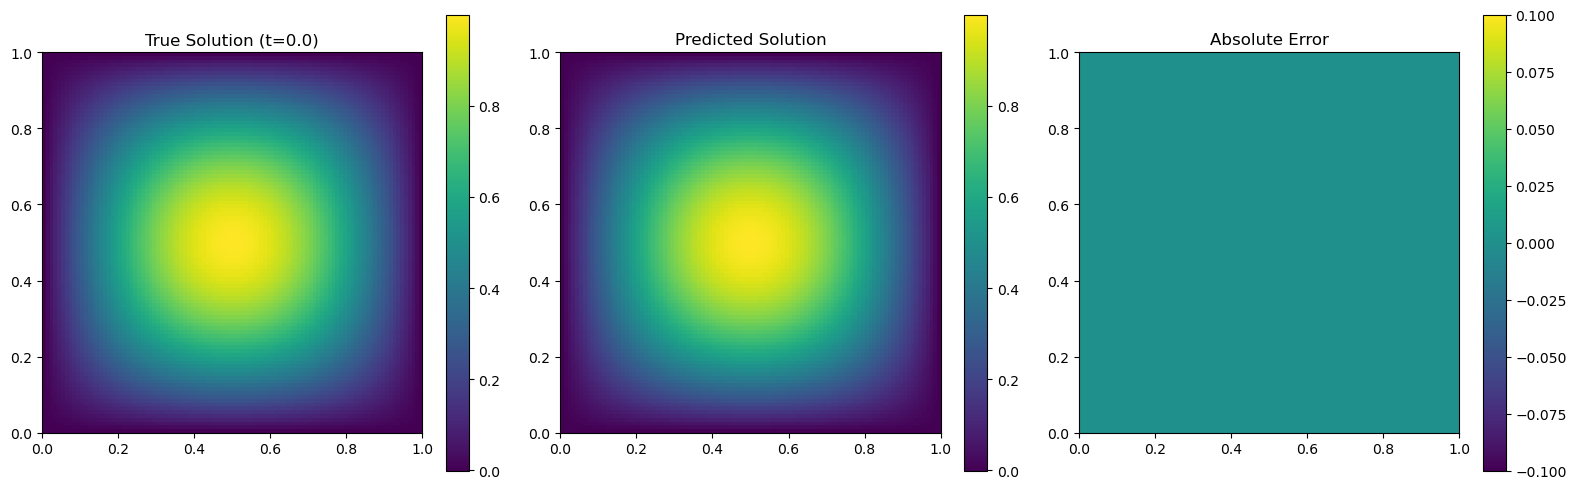

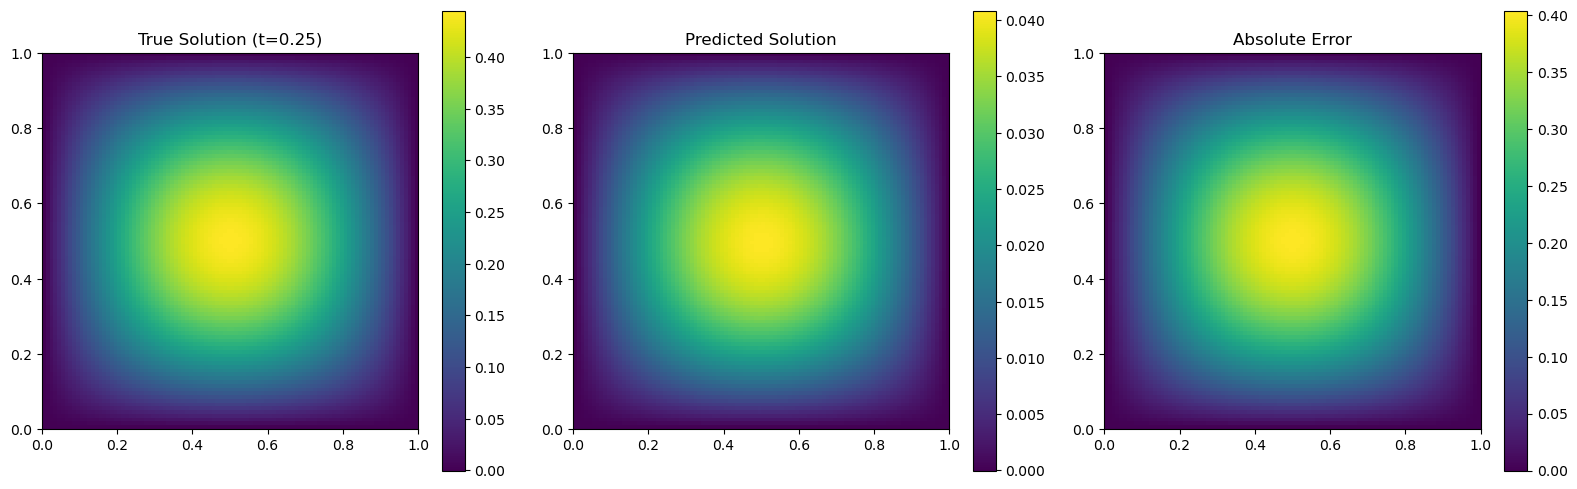

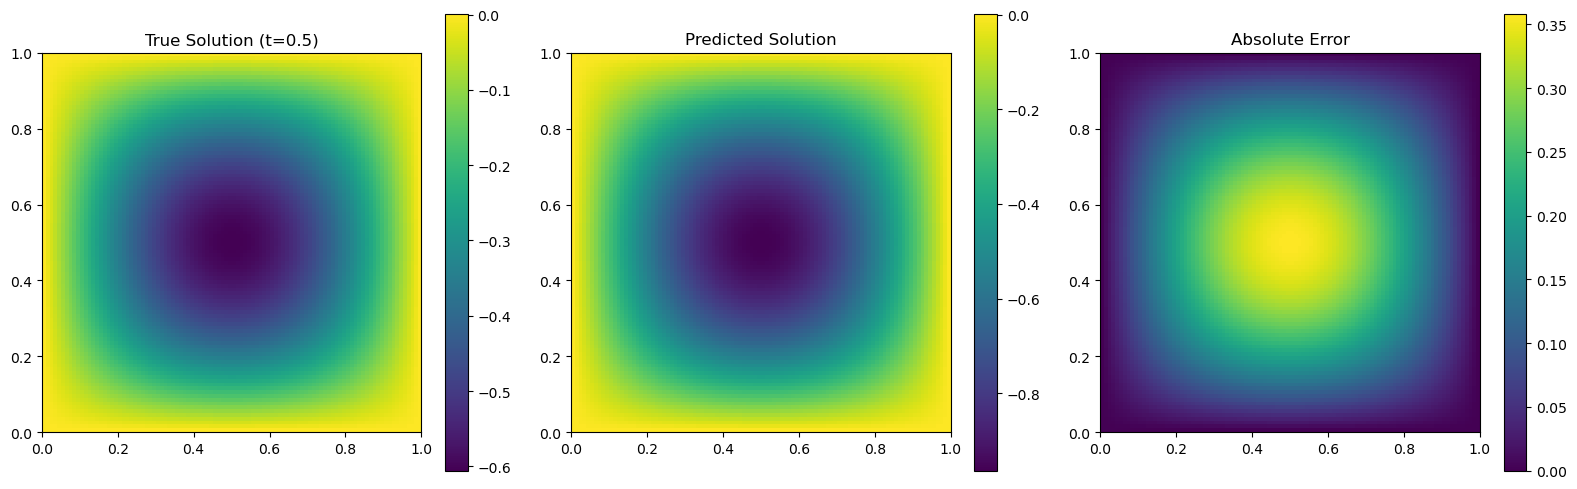

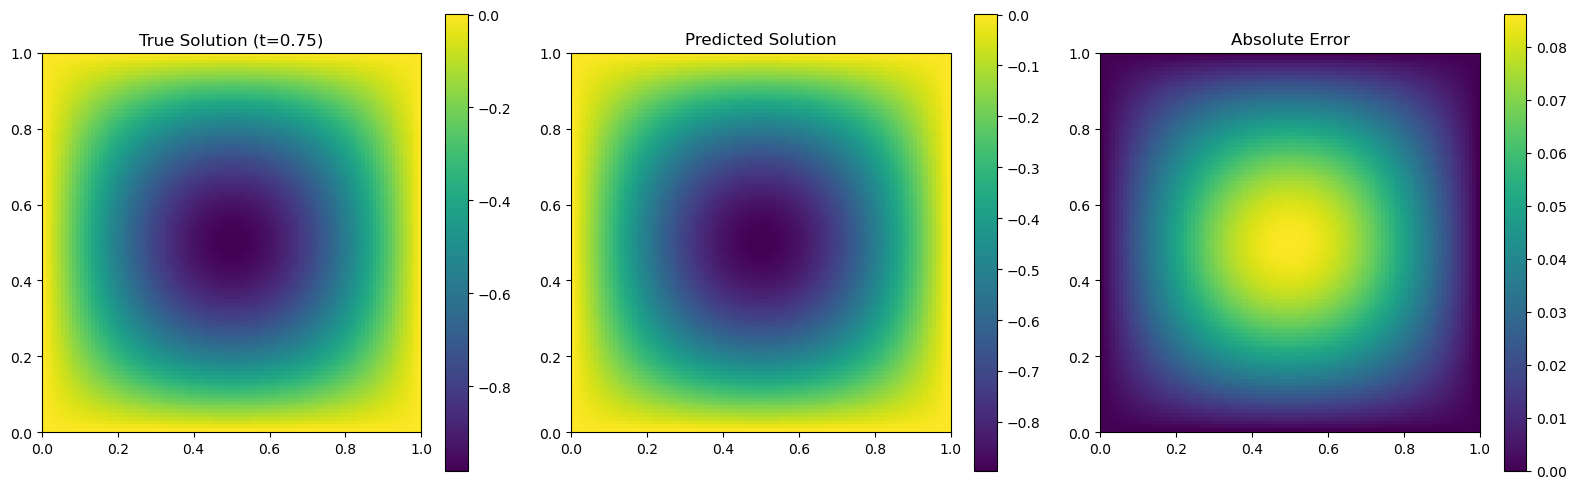

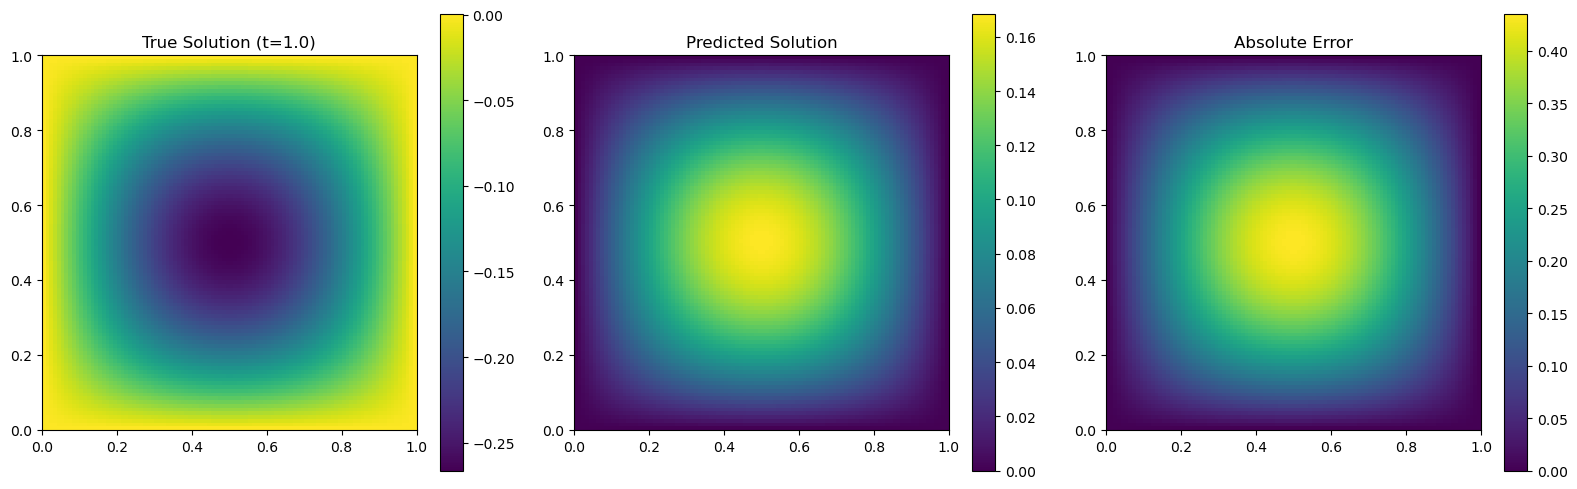

In [79]:
time_points = [0.0, 0.25, 0.5, 0.75, 1.0]

for i in time_points:
    compare_plot(trained_model, t_fixed=i, grid_points=100, device=device)

In [1]:
from IPython.display import HTML
import matplotlib.pyplot as plt
import matplotlib.animation as animation


def animate_solution(model, grid_points=50, frames=60, device='cpu'):
    model.eval()

    x = torch.linspace(0, 1, grid_points)
    y = torch.linspace(0, 1, grid_points)
    X, Y = torch.meshgrid(x, y, indexing='ij')

    x_flat = X.reshape(-1, 1).to(device)
    y_flat = Y.reshape(-1, 1).to(device)

    fig, ax = plt.subplots(figsize=(6, 5))
    img = ax.imshow(np.zeros((grid_points, grid_points)), extent=[0, 1, 0, 1],
                    origin='lower', vmin=-1, vmax=1)
    plt.colorbar(img, ax=ax)
    ax.set_title('Predicted $p(x, y, t)$')

    def update(frame):
        t_val = frame / frames  # time from 0 to 1
        t_flat = torch.full_like(x_flat, t_val).to(device)
        with torch.no_grad():
            p = trial_solution(x_flat, y_flat, t_flat, model)
        p_grid = p.cpu().numpy().reshape(grid_points, grid_points)
        img.set_data(p_grid)
        ax.set_title(f'$p(x, y, t={t_val:.2f})$')
        return [img]

    ani = animation.FuncAnimation(fig, update, frames=frames, interval=100)
    return HTML(ani.to_jshtml())


In [2]:
# Animation
animate_solution(trained_model, device = device)

NameError: name 'trained_model' is not defined